<a href="https://colab.research.google.com/github/kuir-juach/LeafSense_initial_Product/blob/master/Kuir_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Overview**

This software is designed to help identify and classify medicinal plants using Machine Learning techniques. The goal is to support researchers, health practitioners, and communities by providing a reliable tool for recognizing plants that have medicinal value.

**Mount Google Drive**

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [27]:
import os, random, shutil, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout,
                                     Conv2D, MaxPooling2D, Flatten, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from google.colab import files
import math

**Fixing Randomness for Consistency**

In [28]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries loaded and seeds set.")

✅ Libraries loaded and seeds set.


In [30]:
ORIGINAL_DATA_DIR = "/content/drive/MyDrive/data_set_medicinal"
SPLIT_ROOT = "/content/split_medicinal"


**Safety Check and Directory Setup**

In [31]:
# safety check
if not os.path.exists(ORIGINAL_DATA_DIR):
    raise FileNotFoundError(f"Original dataset directory not found: {ORIGINAL_DATA_DIR}")

# remove old split if exists
if os.path.exists(SPLIT_ROOT):
    print(f"Removing existing split folder: {SPLIT_ROOT}")
    shutil.rmtree(SPLIT_ROOT)
os.makedirs(SPLIT_ROOT, exist_ok=True)

Removing existing split folder: /content/split_medicinal


**Create Train, Validation, and Test Splits for Each Class**


In [32]:
# function to split class images
def make_splits_for_class(class_name, src_dir, dst_root, seed=SEED, ratios=(0.7,0.2,0.1)):
    imgs = glob.glob(os.path.join(src_dir, class_name, "*"))
    imgs = [p for p in imgs if os.path.isfile(p)]
    if len(imgs) == 0:
        return 0
    imgs.sort()
    random.Random(seed).shuffle(imgs)
    n = len(imgs)
    n_train = math.floor(ratios[0]*n)
    n_val = math.floor(ratios[1]*n)
    train = imgs[:n_train]
    val = imgs[n_train:n_train+n_val]
    test = imgs[n_train+n_val:]
    def copy_list(lst, split):
        target_dir = os.path.join(dst_root, split, class_name)
        os.makedirs(target_dir, exist_ok=True)
        for p in lst:
            shutil.copy2(p, target_dir)
    copy_list(train, "train")
    copy_list(val, "val")
    copy_list(test, "test")
    return len(imgs)

**Generate and Display Class Distribution After Splitting**

In [33]:
#iterate classes
classes = [d for d in os.listdir(ORIGINAL_DATA_DIR) if os.path.isdir(os.path.join(ORIGINAL_DATA_DIR, d))]
print("Found classes:", classes)
counts = {}
for cls in classes:
    counts[cls] = make_splits_for_class(cls, ORIGINAL_DATA_DIR, SPLIT_ROOT)

#show class distribution before (original) and after (split)
orig_counts = {cls: len(glob.glob(os.path.join(ORIGINAL_DATA_DIR, cls, "*"))) for cls in classes}
split_train_counts = {cls: len(glob.glob(os.path.join(SPLIT_ROOT, "train", cls, "*"))) for cls in classes}
split_val_counts = {cls: len(glob.glob(os.path.join(SPLIT_ROOT, "val", cls, "*"))) for cls in classes}
split_test_counts = {cls: len(glob.glob(os.path.join(SPLIT_ROOT, "test", cls, "*"))) for cls in classes}

dist_df = pd.DataFrame({
    "class": classes,
    "original": [orig_counts[c] for c in classes],
    "train": [split_train_counts[c] for c in classes],
    "val": [split_val_counts[c] for c in classes],
    "test": [split_test_counts[c] for c in classes],
})
display(dist_df)

Found classes: ['Moringa Oleifera (Drumstick)', 'Murraya Koenigii (Curry)', 'Ficus Religiosa (Peepal Tree)', 'Neem', 'Nerium Oleander (Oleander)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Mentha (Mint)', 'Hibiscus Rosa-sinensis', 'Mango', 'Jasminum (Jasmine)', 'Roxburgh fig', 'Citrus Limon (Lemon)', 'Basale', 'Amaranthus Viridis (Arive-Dantu)', 'Carissa Carandas (Karanda)', 'Trigonella Foenum-graecum (Fenugreek)', 'Alpinia Galanga (Rasna)', 'Artocarpus Heterophyllus (Jackfruit)', 'Syzygium Jambos (Rose Apple)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Punica Granatum (Pomegranate)', 'Nyctanthes Arbor-tristis (Parijata)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Syzygium Cumini (Jamun)', 'Guava', 'Ocimum Tenuiflorum (Tulsi)', 'Santalum Album (Sandalwood)']


,class,original,train,val,test
0,Moringa Oleifera (Drumstick),77,53,15,9
1,Murraya Koenigii (Curry),60,42,12,6
2,Ficus Religiosa (Peepal Tree),63,44,12,7
3,Neem,59,41,11,7
4,Nerium Oleander (Oleander),62,43,12,7
5,Muntingia Calabura (Jamaica Cherry-Gasagase),56,39,11,6
6,Mentha (Mint),97,67,19,11
7,Hibiscus Rosa-sinensis,43,30,8,5
8,Mango,62,43,12,7
9,Jasminum (Jasmine),71,49,14,8


**Visualize Class Distribution**

<Figure size 1000x500 with 0 Axes>

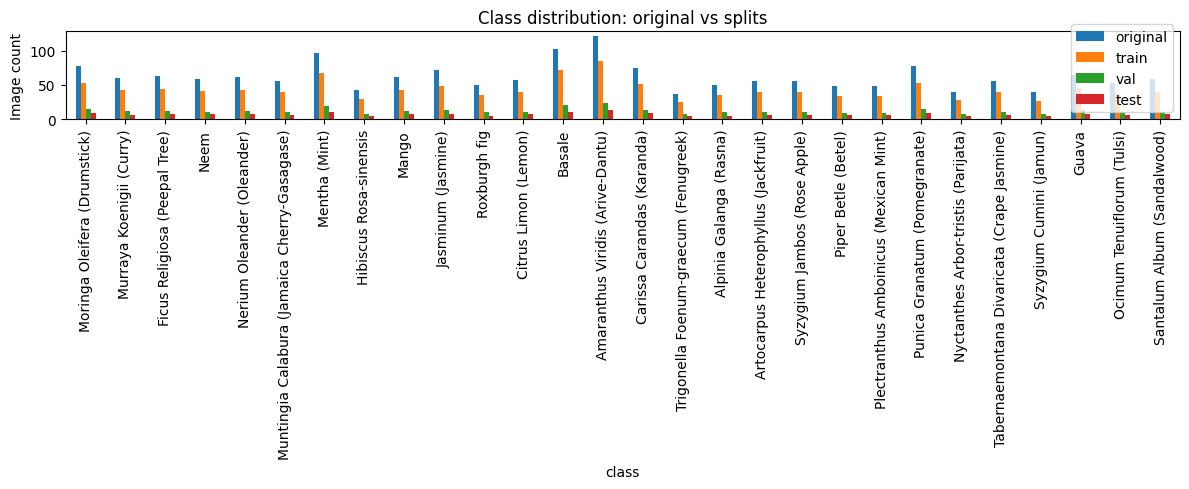

In [34]:
#plot distribution
plt.figure(figsize=(10,5))
dist_df.set_index('class')[['original','train','val','test']].plot(kind='bar', stacked=False, figsize=(12,5))
plt.title("Class distribution: original vs splits")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()


**Create Image Data Generators for Training, Validation, and Testing**

In [35]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.12,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(os.path.join(SPLIT_ROOT, "train"),
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical', shuffle=True, seed=SEED)

val_gen = test_val_datagen.flow_from_directory(os.path.join(SPLIT_ROOT, "val"),
                                               target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                               class_mode='categorical', shuffle=False, seed=SEED)

test_gen = test_val_datagen.flow_from_directory(os.path.join(SPLIT_ROOT, "test"),
                                                target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                class_mode='categorical', shuffle=False, seed=SEED)

num_classes = len(train_gen.class_indices)
print(f"✅ Generators ready. {num_classes} classes detected.")

Found 1205 images belonging to 28 classes.
Found 337 images belonging to 28 classes.
Found 195 images belonging to 28 classes.
✅ Generators ready. 28 classes detected.


**Visualize Preprocessed Images**

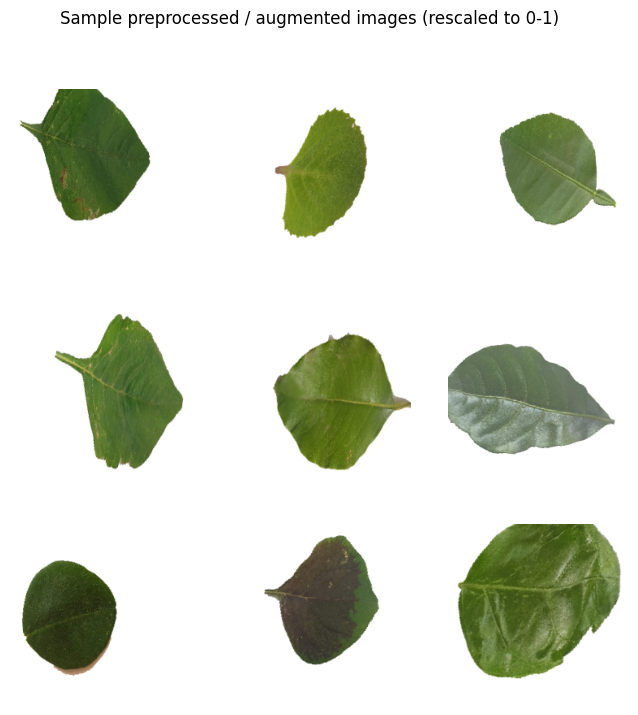

In [38]:
#Visualize some preprocessed / augmented training images
def show_augmented_images(generator, class_name=None, n=9):
    # find a batch that contains images from requested class if provided
    x_batch, y_batch = next(generator)
    fig, axes = plt.subplots(3,3, figsize=(8,8))
    axes = axes.flatten()
    for i in range(n):
        img = x_batch[i]
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle("Sample preprocessed / augmented images (rescaled to 0-1)")
    plt.show()
#display
show_augmented_images(train_gen)

**Baseline CNN Architecture and Compilation**

In [39]:
#Build Baseline CNN (improved with BatchNorm)

def build_baseline_cnn(input_shape=(224,224,3), n_classes=num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = build_baseline_cnn()
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,791,708 (98.39 MB)

 Trainable params: 25,791,260 (98.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
def build_mobilenet(input_shape=(224,224,3), n_classes=num_classes, lr=1e-3):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_efficientnet(input_shape=(224,224,3), n_classes=num_classes, lr=5e-4):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet()
efficientnet_model = build_efficientnet()

#Training helper & callbacks

EPOCHS = 12

def get_common_callbacks(model_name):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
        ModelCheckpoint(f"{model_name}_best.h5", save_best_only=True, monitor='val_loss')
    ]
    return callbacks

In [42]:
#Train baseline CNN
print("Training baseline CNN...")
history_cnn = cnn_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                            callbacks=get_common_callbacks("cnn_baseline"))

# Train MobileNetV2
print("Training MobileNetV2 (transfer learning)...")
history_mobilenet = mobilenet_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                                        callbacks=get_common_callbacks("mobilenet"))

Training baseline CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0332 - loss: 20.6905

38/38 ━━━━━━━━━━━━━━━━━━━━ 286s 7s/step - accuracy: 0.0331 - loss: 20.4281 - val_accuracy: 0.0445 - val_loss: 39.4299 - learning_rate: 0.0010
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.0471 - loss: 3.3536 - val_accuracy: 0.0445 - val_loss: 70.9992 - learning_rate: 0.0010
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.0659 - loss: 3.3272 - val_accuracy: 0.0445 - val_loss: 85.2335 - learning_rate: 0.0010
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0755 - loss: 3.3294
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
38/38 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - accuracy: 0.0754 - loss: 3.3293 - val_accuracy: 0.0445 - val_loss: 83.4653 - learning_rate: 0.0010
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - accuracy: 0.0621 - loss: 3.3251 - val_accuracy: 0.0445 - val_loss: 70.3183 - learning_rate: 5.0000e-04
Training MobileNetV2 (transfer learning)...
Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc

38/38 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1438 - loss: 3.3230 - val_accuracy: 0.6172 - val_loss: 1.4734 - learning_rate: 0.0010
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4942 - loss: 1.6796

38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.4954 - loss: 1.6753 - val_accuracy: 0.7834 - val_loss: 0.7533 - learning_rate: 0.0010
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6883 - loss: 1.0408

38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6884 - loss: 1.0405 - val_accuracy: 0.8872 - val_loss: 0.4665 - learning_rate: 0.0010
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7334 - loss: 0.8435

38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7342 - loss: 0.8415 - val_accuracy: 0.9169 - val_loss: 0.3300 - learning_rate: 0.0010
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7887 - loss: 0.6798

38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7892 - loss: 0.6786 - val_accuracy: 0.9139 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8271 - loss: 0.5480

38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8271 - loss: 0.5479 - val_accuracy: 0.9199 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8402 - loss: 0.5001

38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8404 - loss: 0.4993 - val_accuracy: 0.9466 - val_loss: 0.2039 - learning_rate: 0.0010
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8451 - loss: 0.4607

38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8455 - loss: 0.4598 - val_accuracy: 0.9407 - val_loss: 0.1853 - learning_rate: 0.0010
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8529 - loss: 0.4290 - val_accuracy: 0.9377 - val_loss: 0.1966 - learning_rate: 0.0010
Epoch 10/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8945 - loss: 0.3627

38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8944 - loss: 0.3625 - val_accuracy: 0.9377 - val_loss: 0.1745 - learning_rate: 0.0010
Epoch 11/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8888 - loss: 0.3641

38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8888 - loss: 0.3640 - val_accuracy: 0.9407 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 12/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8777 - loss: 0.3880

38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8778 - loss: 0.3874 - val_accuracy: 0.9466 - val_loss: 0.1525 - learning_rate: 0.0010


**Model Architectures**

This notebook explores three different model architectures for medicinal plant classification:

1.  **Baseline CNN:** A custom-built Convolutional Neural Network with multiple convolutional and pooling layers, followed by dense layers for classification. You can see the definition of this model in the code cell with the `build_baseline_cnn` function.

2.  **MobileNetV2:** A popular pre-trained convolutional neural network architecture known for its efficiency. In this notebook, MobileNetV2 is used as a base model, and new dense layers are added on top for fine-tuning on the medicinal plant dataset. The architecture is defined in the `build_mobilenet` function.

3.  **EfficientNetB0:** Another pre-trained convolutional neural network architecture from the EfficientNet family, known for achieving high accuracy with fewer parameters. Similar to MobileNetV2, it's used as a base model with added dense layers for transfer learning. The architecture is defined in the `build_efficientnet` function.

In [43]:
# Train EfficientNetB0
print("Training EfficientNetB0 (transfer learning)...")
history_efficientnet = efficientnet_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                                              callbacks=get_common_callbacks("efficientnet"))

Training EfficientNetB0 (transfer learning)...
Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0313 - loss: 3.3869

38/38 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.0315 - loss: 3.3863 - val_accuracy: 0.0712 - val_loss: 3.3062 - learning_rate: 5.0000e-04
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0654 - loss: 3.3154

38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.0652 - loss: 3.3156 - val_accuracy: 0.0564 - val_loss: 3.3008 - learning_rate: 5.0000e-04
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.0406 - loss: 3.3135 - val_accuracy: 0.0593 - val_loss: 3.3054 - learning_rate: 5.0000e-04
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0546 - loss: 3.3174

38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.0547 - loss: 3.3175 - val_accuracy: 0.0712 - val_loss: 3.2992 - learning_rate: 5.0000e-04
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0714 - loss: 3.3176

38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.0712 - loss: 3.3175 - val_accuracy: 0.0712 - val_loss: 3.2988 - learning_rate: 5.0000e-04
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0616 - loss: 3.3053

38/38 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.0615 - loss: 3.3055 - val_accuracy: 0.0593 - val_loss: 3.2979 - learning_rate: 5.0000e-04
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0420 - loss: 3.3224

38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.0425 - loss: 3.3222 - val_accuracy: 0.0712 - val_loss: 3.2948 - learning_rate: 5.0000e-04
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0612 - loss: 3.3132

38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.0614 - loss: 3.3130 - val_accuracy: 0.0712 - val_loss: 3.2924 - learning_rate: 5.0000e-04
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.0558 - loss: 3.3106 - val_accuracy: 0.0712 - val_loss: 3.2963 - learning_rate: 5.0000e-04
Epoch 10/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.0574 - loss: 3.3143 - val_accuracy: 0.0712 - val_loss: 3.2965 - learning_rate: 5.0000e-04
Epoch 11/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0643 - loss: 3.3000
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.0642 - loss: 3.3002 - val_accuracy: 0.1039 - val_loss: 3.2928 - learning_rate: 5.0000e-04
Epoch 12/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0714 - loss: 3.3034

38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.0712 - loss: 3.3033 - val_accuracy: 0.0712 - val_loss: 3.2907 - learning_rate: 2.5000e-04


In [44]:
#Experiment Results Table
def best_val_acc(history):
    return max(history.history.get('val_accuracy', [0]))

results = pd.DataFrame({
    "Model": ["Baseline CNN", "MobileNetV2", "EfficientNetB0"],
    "Learning Rate": [1e-3, 1e-3, 5e-4],
    "Epochs (trained)": [len(history_cnn.history['loss']), len(history_mobilenet.history['loss']), len(history_efficientnet.history['loss'])],
    "Best Train Acc": [max(history_cnn.history['accuracy']), max(history_mobilenet.history['accuracy']), max(history_efficientnet.history['accuracy'])],
    "Best Val Acc": [best_val_acc(history_cnn), best_val_acc(history_mobilenet), best_val_acc(history_efficientnet)]
})
display(results)


,Model,Learning Rate,Epochs (trained),Best Train Acc,Best Val Acc
0,Baseline CNN,0.0010,5,0.070539,0.044510
1,MobileNetV2,0.0010,12,0.892116,0.946588
2,EfficientNetB0,0.0005,12,0.068880,0.103858


**Plot Accuracy & Loss**

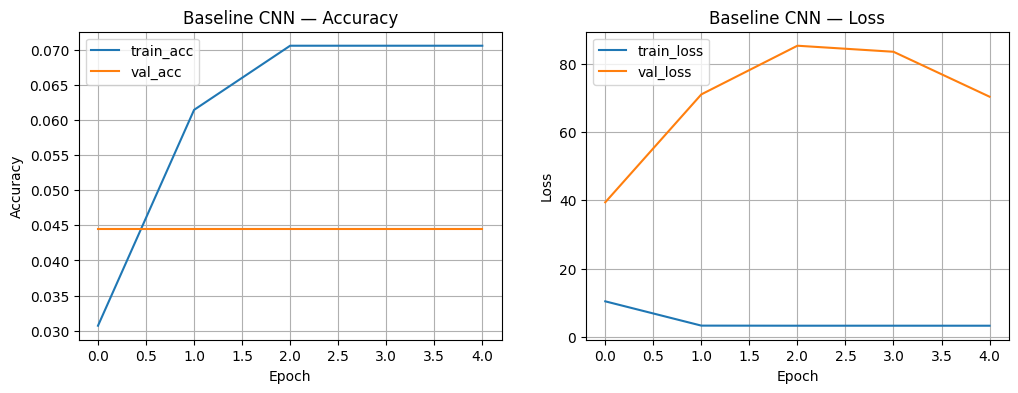

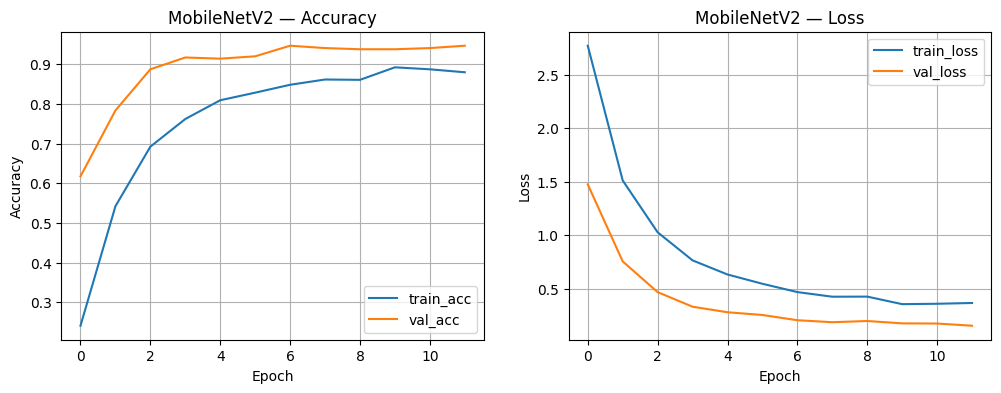

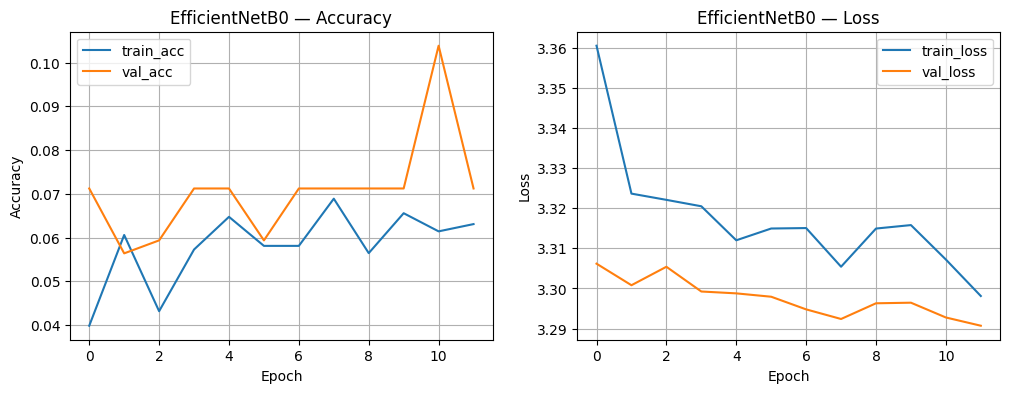

In [45]:
#Ploting accuracy & loss for each model
def plot_history(hist, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(f"{title} — Accuracy")
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f"{title} — Loss")
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_cnn, "Baseline CNN")
plot_history(history_mobilenet, "MobileNetV2")
plot_history(history_efficientnet, "EfficientNetB0")

**Evaluate Performance and Confusion Matrix**

Best model by validation accuracy: MobileNetV2
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


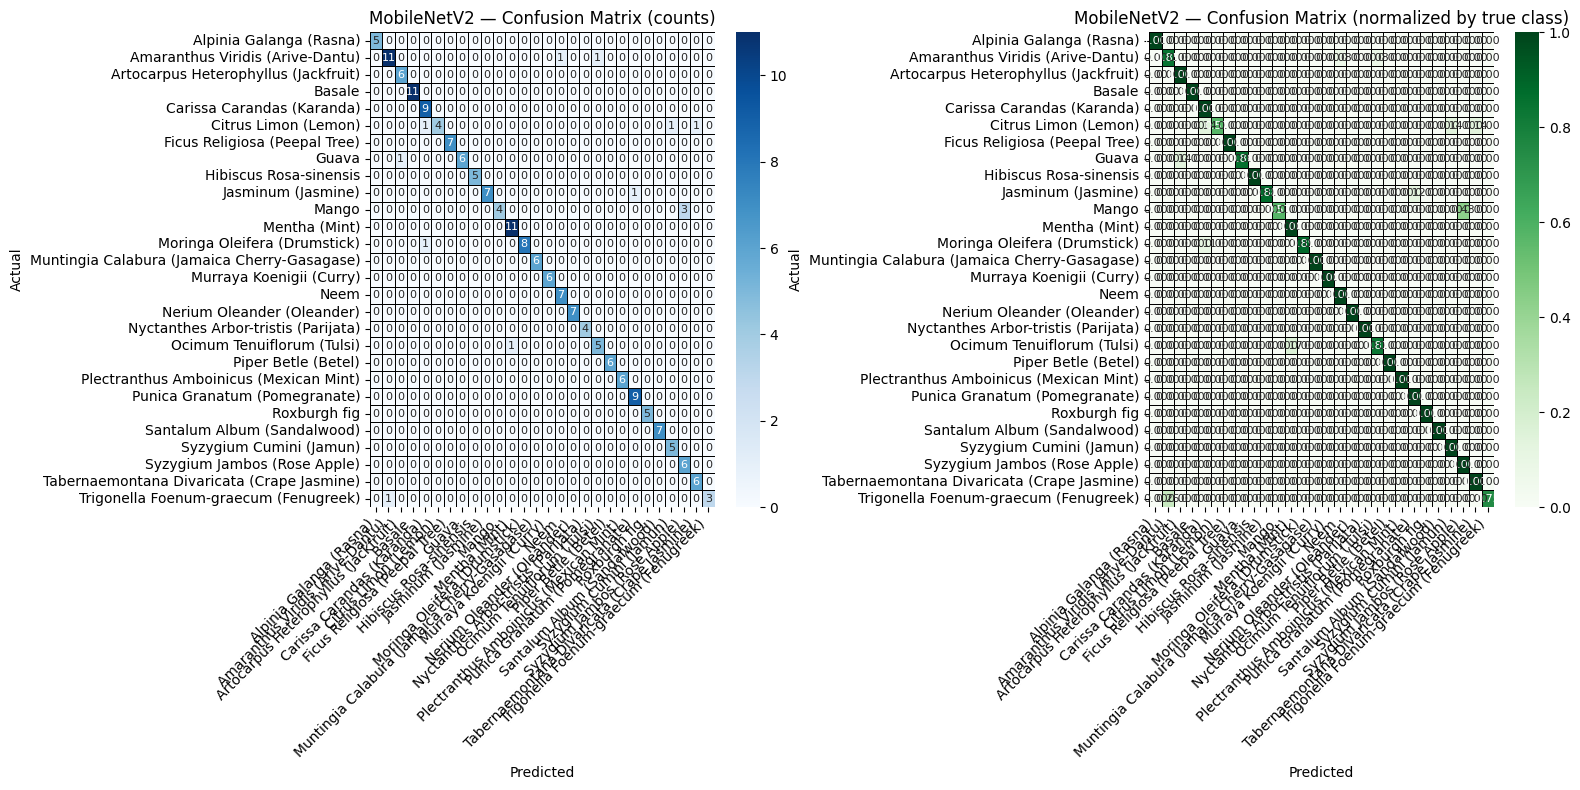

Classification Report:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     1.0000    1.0000    1.0000         5
            Amaranthus Viridis (Arive-Dantu)     0.9167    0.8462    0.8800        13
        Artocarpus Heterophyllus (Jackfruit)     0.8571    1.0000    0.9231         6
                                      Basale     1.0000    1.0000    1.0000        11
                  Carissa Carandas (Karanda)     0.8182    1.0000    0.9000         9
                        Citrus Limon (Lemon)     1.0000    0.5714    0.7273         7
               Ficus Religiosa (Peepal Tree)     1.0000    1.0000    1.0000         7
                                       Guava     1.0000    0.8571    0.9231         7
                      Hibiscus Rosa-sinensis     1.0000    1.0000    1.0000         5
                          Jasminum (Jasmine)     1.0000    0.8750    0.9333         8
                              

In [49]:
#Picking the best model by validation accuracy and evaluate on test set
best_idx = results['Best Val Acc'].idxmax()
best_model_name = results.loc[best_idx, 'Model']
print("Best model by validation accuracy:", best_model_name)

if best_model_name == "Baseline CNN":
    best_model = cnn_model
elif best_model_name == "MobileNetV2":
    best_model = mobilenet_model
else:
    best_model = efficientnet_model

#Ensure test_gen starts from beginning
test_gen.reset()
preds = best_model.predict(test_gen, verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_gen.classes
label_names = list(test_gen.class_indices.keys())

#Confusion matrix (count + normalized)
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 8)) # Increased figure size for better readability
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            annot_kws={"size": 8}, linewidths=.5, linecolor='black') # Added annot_kws, linewidths, and linecolor
plt.title(f"{best_model_name} — Confusion Matrix (counts)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0) # Keep y-axis labels horizontal

plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Greens',
            xticklabels=label_names, yticklabels=label_names,
            annot_kws={"size": 8}, linewidths=.5, linecolor='black') # Added annot_kws, linewidths, and linecolor
plt.title(f"{best_model_name} — Confusion Matrix (normalized by true class)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0) # Keep y-axis labels horizontal
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_names, digits=4))

**Saving the Best Model**

In [47]:
#Save best model and convert to TFLite
best_model.save("best_medicinal_plant_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
open("best_medicinal_plant_model.tflite","wb").write(tflite_model)
print("✅ Saved best model (.h5) and exported .tflite for mobile deployment.")

Saved artifact at '/tmp/tmphre11ria'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1008')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  138493367781136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367779984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367783056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367782672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367782864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367782288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367779600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367782480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367780752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138493367784016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13849336

In [48]:
print("\n---- Image upload & predict ----")
print("Run the next cell when you want to upload an image and get a prediction.")

# helper function to preprocess and predict a single image
def predict_uploaded_image(model, img_path, label_map, img_size=IMG_SIZE):
    img = load_img(img_path, target_size=img_size)
    arr = img_to_array(img)/255.0
    plt.imshow(arr); plt.axis('off'); plt.title("Uploaded image (rescaled)")
    plt.show()
    x = np.expand_dims(arr, axis=0)
    preds = model.predict(x)
    top_idx = np.argmax(preds, axis=1)[0]
    top_prob = preds[0, top_idx]
    class_name = label_map[top_idx]
    print(f"Prediction: {class_name} — probability: {top_prob:.4f}")
    # show soft probabilities for top 3
    top3 = np.argsort(preds[0])[-3:][::-1]
    print("Top 3 predictions:")
    for i in top3:
        print(f" - {label_map[i]}: {preds[0,i]:.4f}")

# Usage cell (paste into Colab and run when ready):
# uploaded = files.upload()
# for fn in uploaded.keys():
#     predict_uploaded_image(best_model, fn, label_names)

print("To predict: run the commented `files.upload()` block shown above in a new cell.")


---- Image upload & predict ----
Run the next cell when you want to upload an image and get a prediction.
To predict: run the commented `files.upload()` block shown above in a new cell.
